In [1]:
from torch import tensor
import os
from tqdm import tqdm
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
# import numpy as np
from numpy import array
from numpy import int64
from numpy import float32

## Enter Dataset, transition matrix, and features

In [2]:
folder = '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments'
dataset = 'tdrive'  # pneuma, tdrive, geolife, munich
model = 'residual'  # residual, GAT, MLP
transition_matrix = 'marginal_prior'    # custom, marginal_prior
noising = 'cosine'  # cosine, linear
features = 'one_hot_edges_coordinates_pos_encoding_pw_distance_edge_length_edge_angles_num_pred_edges_future_len'
history = 5
future = 0

# Single sample
Metrics

# Multiplte sample
Metrics

## Load Data

In [15]:
sample_list = torch.load("/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments/tdrive_rnn/tdrive_rnn_lstm_hist5_fut0_pred_list.pth")
ground_truth_hist = torch.load("/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments/tdrive_rnn/tdrive_rnn_lstm_hist5_fut0_gt_hist.pth")
ground_truth_fut = torch.load("/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/experiments/tdrive_rnn/tdrive_rnn_lstm_hist5_fut0_gt_fut.pth")

/tmp/ipykernel_317507/4135656147.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_list = torch.load("/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_predi

In [16]:
res = {'sample_list': [torch.tensor(sample) for sample in sample_list], 'ground_truth_hist': [torch.tensor(gt_hist) for gt_hist in ground_truth_hist], 'ground_truth_fut': [torch.tensor(gt_fut) for gt_fut in ground_truth_fut]}

## Load Graph

In [18]:
def load_new_format(file_path, device):
        paths = []
        with h5py.File(file_path, 'r') as new_hf:
            node_coordinates = torch.tensor(new_hf['graph']['node_coordinates'][:], dtype=torch.float, device=device)
            #edges = torch.tensor(new_hf['graph']['edges'][:], dtype=torch.long, device=device)
            edges = new_hf['graph']['edges'][:]
            edge_coordinates = node_coordinates[edges]
            nodes = [(i, {'pos': torch.tensor(pos, device=device)}) for i, pos in enumerate(node_coordinates)]
            #edges = [(torch.tensor(edge[0], device=device), torch.tensor(edge[1], device=device)) for edge in edges]
            edges = [tuple(edge) for edge in edges]

            '''nodes = [(i, {'pos': tuple(pos)}) for i, pos in enumerate(node_coordinates)]
            edges = [tuple(edge) for edge in edges]'''

            for i in tqdm(new_hf['trajectories'].keys()):
                path_group = new_hf['trajectories'][i]
                path = {attr: torch.tensor(path_group[attr][()], device=device) for attr in path_group.keys() if attr in ['coordinates', 'edge_idxs', 'edge_orientations']}
                # path = {attr: path_group[attr][()] for attr in path_group.keys()}
                paths.append(path)
            
        return paths, nodes, edges, edge_coordinates
    
paths, nodes, edges, edge_coordinates = load_new_format(f'/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive_test.h5', 'cpu')
indexed_edges = [((start, end), index) for index, (start, end) in enumerate(edges)]
G = nx.Graph()
G.add_nodes_from(nodes)
for (start, end), index in indexed_edges:
        G.add_edge(start, end, index=index, default_orientation=(start, end))

/tmp/ipykernel_317507/784945742.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nodes = [(i, {'pos': torch.tensor(pos, device=device)}) for i, pos in enumerate(node_coordinates)]
100%|██████████| 697/697 [00:01<00:00, 595.83it/s]


In [19]:
def creat_adjaency_matrix(nodes, stop_token, edges):
    edge_to_nodes = {}
    G = nx.Graph()
    G.add_nodes_from(nodes)
    indexed_edges = [((start, end), index) for index, (start, end) in enumerate(edges)]
    for (start, end), index in indexed_edges:
        G.add_edge(start, end, index=index, default_orientation=(start, end))
        edge_to_nodes.update({index: set([start, end])})

    degrees = G.degree()
    average_degree = sum(deg for _, deg in degrees) / float(len(G))
    avg_degree = average_degree
    adjacency_matrix = torch.zeros((stop_token+2, stop_token+2), dtype=torch.bool)

    # Populate the adjacency matrix
    for edge1, nodes1 in edge_to_nodes.items():
        for edge2, nodes2 in edge_to_nodes.items():
            if edge1 != edge2 and not nodes1.isdisjoint(nodes2):
                adjacency_matrix[edge1, edge2] = True
                adjacency_matrix[edge2, edge1] = True  # Ensure symmetry since the graph is undirected

    stop_token_index = stop_token
    #adjacency_matrix[-1, :] = True
    adjacency_matrix[:, -2] = True  # Stop token must be reachable from any edge
    adjacency_matrix[:, -1] = True  # Padding token must be reachable from any edge
    
    return adjacency_matrix

adj_mat = creat_adjaency_matrix(nodes, len(edges), edges)

In [7]:
print(torch.argwhere(adj_mat[1027] == 1))

tensor([[  943],
        [  946],
        [ 1561],
        [ 1959],
        [12806],
        [12807]])


In [8]:
print(edges[1027])
print(edges[246])
print(edges[1026])
print(edges[1029])
print(edges[1030])
print(edges[1050])
print(edges[1371])

(4067, 2518)
(916, 646)
(834, 5282)
(436, 1000)
(3985, 848)
(514, 7824)
(3511, 5547)


## Plot Single Sample

tensor([8393.,  419.,  417., 5406., 6038.])
tensor([ 9564,  1508,  1507, 11038,  1401,  1403])
tensor([ 9563, 16365,  5361,  5364,  5362])


tensor([15572.,  1244.,  1246., 14601., 11798.])
tensor([11670, 11672, 10562,  5756,  2675,  2676,  4242,  4244])
tensor([11670, 11672, 10562,  5756,  2675,  2674])
tensor([ 2027.,  2025., 11911., 11912., 11913.])
tensor([2033, 2034, 6584, 6585, 9603, 9602, 1225, 1224,  324,   63,   60])
tensor([11914,  2959,  2958,  2957, 11906, 11905, 13316])
tensor([14843.,  8599.,  8601.,  6571.,  6570.])
tensor([16525, 15393, 15394,  4101,  4102, 16188,  5285,  5286,  5262,   342,
          341])
tensor([], dtype=torch.int64)
tensor([ 2364., 12779., 12777., 13857.,  2352.])
tensor([2351, 2354, 2353, 2612, 2613, 8901, 8902, 9658, 1143, 1144, 1147, 8088,
        8087, 5847])
tensor([2351, 2354, 2353, 2612, 2613, 8901, 8902, 9658, 1143, 1146, 4538, 4537,
         262])
tensor([ 9288.,  1339.,  1337., 11951., 15232.])
tensor([15231, 15097, 14057,  9057,  7176,  1154,  1153,  2928, 15195, 15194,
        16497])
tensor([15231, 15097, 14057, 14056,  1156,  1158,  1155])
tensor([ 8201.,  8200.,  9668., 14

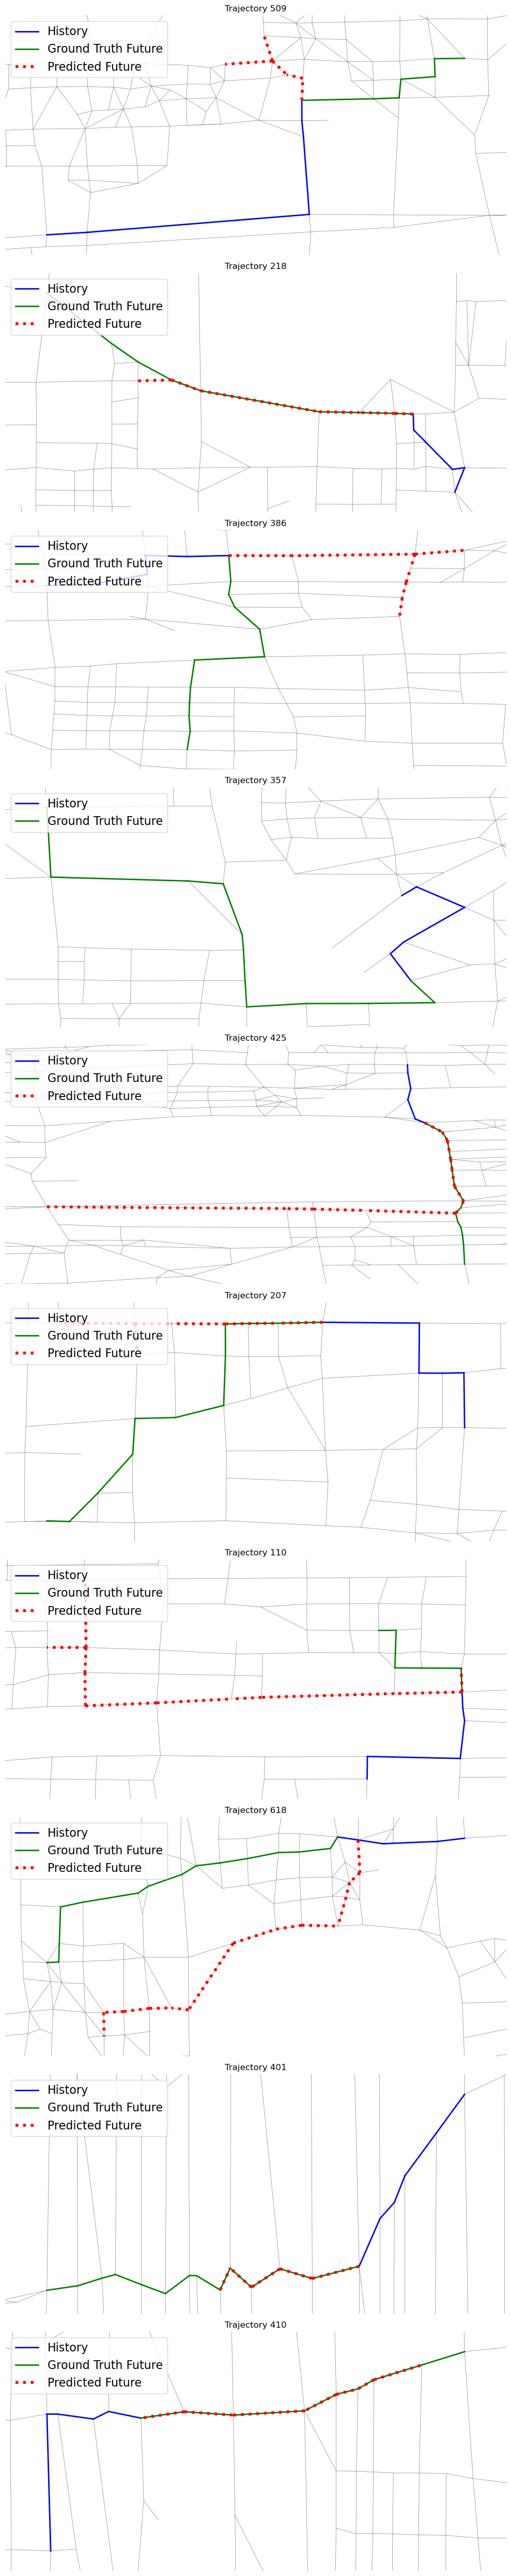

In [20]:
def plot_paths_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, zoom_in=True, valid=False, valid_ids=None):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    while path_count < num_paths_to_plot:
        idx = torch.randint(0, len(ground_truth_hist), (1,)).item()
        
        ax = axs[path_count]
        if idx >= len(ground_truth_hist):
            continue
        
        if zoom_in:
            print(torch.flatten(ground_truth_hist[idx]))
            print(ground_truth_fut[idx])
            print(samples[idx])
            all_edges = torch.cat([torch.flatten(ground_truth_hist[idx]).long(), ground_truth_fut[idx], samples[idx]])
            if all_edges.numel() > 0:
                all_edges = all_edges.long()
                all_coords = edge_coordinates[all_edges].view(-1, 2)
                xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                margin = (xmax - xmin) * 0.1
                xmin -= margin
                xmax += margin
                ax.set_xlim(xmin[0].item(), xmax[0].item())
                ax.set_ylim(xmin[1].item(), xmax[1].item())
        # Plot all edges as background
        for edge in edge_coordinates:
            ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)
        
        # Define the plot_trajectory within this function to ensure it uses 'ax'
        def plot_trajectory(edge_indices, color, label):
            added_label = False  # Flag to add label only once
            if edge_indices.dim() == 2:
                edge_indices = edge_indices.squeeze(0)
            if edge_indices.numel() > 0:
                for edge_idx in edge_indices:
                    edge = edge_coordinates[edge_idx]
                    line_style = ':' if label == 'Predicted Future' else '-'  # Use dotted lines for 'Predicted Future'
                    lw = 4 if label == 'Predicted Future' else 2  # Use thicker lines for 'Predicted Future'
                    if not added_label:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)
                        added_label = True
                    else:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style)

        plot_trajectory(torch.flatten(ground_truth_hist[idx]).long(), 'blue', 'History')
        plot_trajectory(ground_truth_fut[idx], 'green', 'Ground Truth Future')
        plot_trajectory(samples[idx], 'red', 'Predicted Future')

        ax.set_title(f'Trajectory {idx+1}')
        ax.legend(loc='upper left', fontsize=16)
        ax.axis('off')

        path_count += 1  # Increment the path counter
    plt.tight_layout()
    plt.show()

plot_paths_random(res['ground_truth_hist'], res['ground_truth_fut'], res['sample_list'], edge_coordinates, num_paths_to_plot=10, zoom_in=True)

## Plot Valid Samples

In [ ]:
plot_paths_random(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_valid'], edge_coordinates, num_paths_to_plot=10, zoom_in=True, valid=True, valid_ids=res['valid_ids'])

## Plot Path Density Random

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import matplotlib.lines as mlines

def plot_path_density_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, random=False, start_id=0, zoom_in=True):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    path_count = 0
    while path_count < num_paths_to_plot:
        batch_idx = torch.randint(0, len(ground_truth_hist), (1,)).item()
        idx = torch.randint(0, len(ground_truth_hist[batch_idx]), (1,)).item()
        
        ax = axs[path_count]
        if idx >= len(ground_truth_hist[batch_idx]):
            continue

        # Configure zooming in on relevant trajectories
        all_samples_edges = torch.cat([sample[idx] for sample in samples[batch_idx]])
        all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx], all_samples_edges])
        if zoom_in:
            # all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx]] + [sample[idx] for sample in samples[batch_idx]])
            if all_edges.numel() > 0:
                all_coords = edge_coordinates[all_edges].view(-1, 2)
                xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                margin = (xmax - xmin) * 0.1
                xmin -= margin
                xmax += margin
                ax.set_xlim(xmin[0].item(), xmax[0].item())
                ax.set_ylim(xmin[1].item(), xmax[1].item())

        # Plot background edges
        for edge in edge_coordinates:
            ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)
            
        # Track how often each edge is used in samples
        edge_count = {}
        for sample in samples[batch_idx]:
            for edge_idx in sample[idx]:
                edge_count[edge_idx.item()] = edge_count.get(edge_idx.item(), 0) + 1

        max_count = max(edge_count.values()) if edge_count else 1
                
                
        # Define the plot_trajectory within this function to ensure it uses 'ax'
        def plot_trajectory(edge_indices, color, label):
            if isinstance(edge_indices, dict):
                edge_indices = edge_indices.items()
                added_label = False  # Flag to add label only once
                for edge_idx, count in edge_indices:
                    edge = edge_coordinates[edge_idx]
                    ax.plot(edge[:, 0], edge[:, 1], color='red', linewidth=2 + 3 * (count / max_count), alpha=0.3 + 0.7 * (count / max_count), linestyle='--')
            else:
                added_label = False  # Flag to add label only once
                if edge_indices.dim() == 2:
                    edge_indices = edge_indices.squeeze(0)
                if edge_indices.numel() > 0:
                    for edge_idx in edge_indices:
                        edge = edge_coordinates[edge_idx]
                        line_style = '-'
                        lw = 2
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)

        plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History')
        plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future')
        plot_trajectory(edge_count, 'red', 'Predicted Future')
        
        custom_handle1 = mlines.Line2D([], [], color='blue', linestyle='-', markersize=15, label='History')
        custom_handle2 = mlines.Line2D([], [], color='green', linestyle='-', markersize=15, label='Ground Truth Future')
        custom_handle3 = mlines.Line2D([], [], color='red', linestyle='--', markersize=15, label='Predicted Future')


        ax.set_title(f'Trajectory {idx+1} of batch {batch_idx+1}')
        ax.legend(handles=[custom_handle1, custom_handle2, custom_handle3], loc='upper left', fontsize=12)
        ax.axis('off')

        path_count += 1  # Increment the path counter

    plt.tight_layout()
    plt.show()

plot_path_density_random(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_raw'], edge_coordinates, num_paths_to_plot=10, zoom_in=True)

## Plot Multiple Samples

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

def plot_multiple_paths_random(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, random=False, start_id=0, zoom_in=True):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    path_count = 0
    while path_count < num_paths_to_plot:
        batch_idx = torch.randint(0, len(ground_truth_hist), (1,)).item()
        idx = torch.randint(0, len(ground_truth_hist[batch_idx]), (1,)).item()
        
        ax = axs[path_count]
        if idx >= len(ground_truth_hist[batch_idx]):
            continue

        # Configure zooming in on relevant trajectories
        all_samples_edges = torch.cat([sample[idx] for sample in samples[batch_idx]])
        all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx], all_samples_edges])
        if zoom_in:
            # all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx]] + [sample[idx] for sample in samples[batch_idx]])
            if all_edges.numel() > 0:
                all_coords = edge_coordinates[all_edges].view(-1, 2)
                xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                margin = (xmax - xmin) * 0.1
                xmin -= margin
                xmax += margin
                ax.set_xlim(xmin[0].item(), xmax[0].item())
                ax.set_ylim(xmin[1].item(), xmax[1].item())

        # Plot background edges
        for edge in edge_coordinates:
            ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)

        # Define the plot_trajectory within this function to ensure it uses 'ax'
        def plot_trajectory(edge_indices, color, label):
            added_label = False  # Flag to add label only once
            if edge_indices.dim() == 2:
                edge_indices = edge_indices.squeeze(0)
            if edge_indices.numel() > 0:
                for edge_idx in edge_indices:
                    edge = edge_coordinates[edge_idx]
                    line_style = '-' if 'Predicted' in label else '-'  # Use dotted lines for 'Predicted Future'
                    lw = 4 if 'Predicted' in label else 2
                    alpha = 0.5 if 'Predicted' in label else 1
                    if not added_label:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)
                        added_label = True
                    else:
                        ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style)

        plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History')
        plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future')
        
        # Plot all samples for this data point
        sample_colors = cm.get_cmap('tab10', len(samples[batch_idx]))
        for j, sample in enumerate(samples[batch_idx]):
            plot_trajectory(sample[idx], sample_colors(j), f'Predicted Future {j+1}')

        ax.set_title(f'Trajectory {idx+1} of batch {batch_idx+1}')
        ax.legend(loc='upper left')
        ax.axis('off')

        path_count += 1  # Increment the path counter

    plt.tight_layout()
    plt.show()

plot_multiple_paths_random(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_raw'], edge_coordinates, num_paths_to_plot=10, zoom_in=True)

In [ ]:
'''def plot_paths(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, random=False, start_id=0, zoom_in=True):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    for batch_idx in range(len(ground_truth_hist)):
        # Determine the starting index
        start_idx = torch.randint(0, len(ground_truth_hist[batch_idx]) - num_paths_to_plot + 1, (1,)).item() if random else start_id
        for i in range(len(ground_truth_hist[batch_idx])):
            if path_count >= num_paths_to_plot:
                break  # Stop if we have plotted the desired number of paths

            ax = axs[path_count]
            idx = start_idx + i
            if idx >= len(ground_truth_hist[batch_idx]):
                continue  # Prevent indexing beyond the number of samples

            # Configure zooming in on relevant trajectories
            if zoom_in:
                all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx], samples[batch_idx][idx]])
                if all_edges.numel() > 0:
                    all_coords = edge_coordinates[all_edges].view(-1, 2)
                    xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                    margin = (xmax - xmin) * 0.1
                    xmin -= margin
                    xmax += margin
                    ax.set_xlim(xmin[0].item(), xmax[0].item())
                    ax.set_ylim(xmin[1].item(), xmax[1].item())

            # Plot all edges as background
            for edge in edge_coordinates:
                ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)

            # Define the plot_trajectory within this function to ensure it uses 'ax'
            def plot_trajectory(edge_indices, color, label):
                added_label = False  # Flag to add label only once
                if edge_indices.dim() == 2:
                    edge_indices = edge_indices.squeeze(0)
                if edge_indices.numel() > 0:
                    for edge_idx in edge_indices:
                        edge = edge_coordinates[edge_idx]
                        line_style = ':' if label == 'Predicted Future' else '-'  # Use dotted lines for 'Predicted Future'
                        lw = 4 if label == 'Predicted Future' else 2  # Use thicker lines for 'Predicted Future'
                        if not added_label:
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)
                            added_label = True
                        else:
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style)

            plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History')
            plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future')
            plot_trajectory(samples[batch_idx][idx], 'red', 'Predicted Future')

            ax.set_title(f'Trajectory {idx+1} of batch {batch_idx+1}')
            ax.legend(loc='upper left', fontsize=16)
            ax.axis('off')

            path_count += 1  # Increment the path counter

    plt.tight_layout()
    plt.show()

plot_paths(res['ground_truth_hist'], res['ground_truth_fut'], res['sample_list'], edge_coordinates, num_paths_to_plot=70, zoom_in=True)'''

In [ ]:
'''import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import matplotlib.lines as mlines

def plot_path_density(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, random=False, start_id=0, zoom_in=True):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    for batch_idx in range(len(ground_truth_hist)):
        # Determine the starting index
        start_idx = torch.randint(0, len(ground_truth_hist[batch_idx]) - num_paths_to_plot + 1, (1,)).item() if random else start_id
        for i in range(len(ground_truth_hist[batch_idx])):
            if path_count >= num_paths_to_plot:
                break  # Stop if we have plotted the desired number of paths

            ax = axs[path_count]
            idx = start_idx + i
            if idx >= len(ground_truth_hist[batch_idx]):
                continue  # Prevent indexing beyond the number of samples

            # Configure zooming in on relevant trajectories
            all_samples_edges = torch.cat([sample[idx] for sample in samples[batch_idx]])
            all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx], all_samples_edges])
            if zoom_in:
                # all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx]] + [sample[idx] for sample in samples[batch_idx]])
                if all_edges.numel() > 0:
                    all_coords = edge_coordinates[all_edges].view(-1, 2)
                    xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                    margin = (xmax - xmin) * 0.1
                    xmin -= margin
                    xmax += margin
                    ax.set_xlim(xmin[0].item(), xmax[0].item())
                    ax.set_ylim(xmin[1].item(), xmax[1].item())

            # Plot background edges
            for edge in edge_coordinates:
                ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)
                
            # Track how often each edge is used in samples
            edge_count = {}
            for sample in samples[batch_idx]:
                for edge_idx in sample[idx]:
                    edge_count[edge_idx.item()] = edge_count.get(edge_idx.item(), 0) + 1

            max_count = max(edge_count.values()) if edge_count else 1
                
                
            # Define the plot_trajectory within this function to ensure it uses 'ax'
            def plot_trajectory(edge_indices, color, label):
                if isinstance(edge_indices, dict):
                    edge_indices = edge_indices.items()
                    added_label = False  # Flag to add label only once
                    for edge_idx, count in edge_indices:
                        edge = edge_coordinates[edge_idx]
                        ax.plot(edge[:, 0], edge[:, 1], color='red', linewidth=2 + 3 * (count / max_count), alpha=0.3 + 0.7 * (count / max_count), linestyle='--')
                else:
                    added_label = False  # Flag to add label only once
                    if edge_indices.dim() == 2:
                        edge_indices = edge_indices.squeeze(0)
                    if edge_indices.numel() > 0:
                        for edge_idx in edge_indices:
                            edge = edge_coordinates[edge_idx]
                            line_style = '-'
                            lw = 2
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)

            plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History')
            plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future')
            plot_trajectory(edge_count, 'red', 'Predicted Future')
            
            custom_handle1 = mlines.Line2D([], [], color='blue', linestyle='-', markersize=15, label='History')
            custom_handle2 = mlines.Line2D([], [], color='green', linestyle='-', markersize=15, label='Ground Truth Future')
            custom_handle3 = mlines.Line2D([], [], color='red', linestyle='--', markersize=15, label='Predicted Future')


            ax.set_title(f'Trajectory {idx+1} of batch {batch_idx+1}')
            ax.legend(handles=[custom_handle1, custom_handle2, custom_handle3], loc='upper left', fontsize=12)
            ax.axis('off')

            path_count += 1  # Increment the path counter

    plt.tight_layout()
    plt.show()

plot_path_density(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_raw'], edge_coordinates, num_paths_to_plot=50, zoom_in=True)'''

In [ ]:
'''import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

def plot_multiple_paths(ground_truth_hist, ground_truth_fut, samples, edge_coordinates, num_paths_to_plot=4, random=False, start_id=0, zoom_in=True):
    # Setup the subplot layout based on num_paths_to_plot
    fig, axs = plt.subplots(num_paths_to_plot, 1, figsize=(10, 5 * num_paths_to_plot), squeeze=False)
    axs = axs.flatten()  # Flatten in case of a single subplot to standardize indexing

    path_count = 0
    for batch_idx in range(len(ground_truth_hist)):
        # Determine the starting index
        start_idx = torch.randint(0, len(ground_truth_hist[batch_idx]) - num_paths_to_plot + 1, (1,)).item() if random else start_id
        for i in range(len(ground_truth_hist[batch_idx])):
            if path_count >= num_paths_to_plot:
                break  # Stop if we have plotted the desired number of paths

            ax = axs[path_count]
            idx = start_idx + i
            if idx >= len(ground_truth_hist[batch_idx]):
                continue  # Prevent indexing beyond the number of samples

            # Configure zooming in on relevant trajectories
            if zoom_in:
                all_edges = torch.cat([ground_truth_hist[batch_idx][idx], ground_truth_fut[batch_idx][idx]] + [sample[idx] for sample in samples[batch_idx]])
                if all_edges.numel() > 0:
                    all_coords = edge_coordinates[all_edges].view(-1, 2)
                    xmin, xmax = all_coords.min(0)[0], all_coords.max(0)[0]
                    margin = (xmax - xmin) * 0.1
                    xmin -= margin
                    xmax += margin
                    ax.set_xlim(xmin[0].item(), xmax[0].item())
                    ax.set_ylim(xmin[1].item(), xmax[1].item())

            # Plot all edges as background
            for edge in edge_coordinates:
                ax.plot(edge[:, 0], edge[:, 1], color='grey', linewidth=0.5)

            # Define the plot_trajectory within this function to ensure it uses 'ax'
            def plot_trajectory(edge_indices, color, label):
                added_label = False  # Flag to add label only once
                if edge_indices.dim() == 2:
                    edge_indices = edge_indices.squeeze(0)
                if edge_indices.numel() > 0:
                    for edge_idx in edge_indices:
                        edge = edge_coordinates[edge_idx]
                        line_style = '-' if 'Predicted' in label else '-'  # Use dotted lines for 'Predicted Future'
                        lw = 4 if 'Predicted' in label else 2
                        alpha = 0.5 if 'Predicted' in label else 1
                        if not added_label:
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style, label=label)
                            added_label = True
                        else:
                            ax.plot(edge[:, 0], edge[:, 1], color=color, linewidth=lw, linestyle=line_style)

            plot_trajectory(ground_truth_hist[batch_idx][idx], 'blue', 'History')
            plot_trajectory(ground_truth_fut[batch_idx][idx], 'green', 'Ground Truth Future')
            
            # Plot all samples for this data point
            sample_colors = cm.get_cmap('tab10', len(samples[batch_idx]))
            for j, sample in enumerate(samples[batch_idx]):
                plot_trajectory(sample[idx], sample_colors(j), f'Predicted Future {j+1}')

            ax.set_title(f'Trajectory {idx+1} of batch {batch_idx+1}')
            ax.legend(loc='upper left')
            ax.axis('off')

            path_count += 1  # Increment the path counter

    plt.tight_layout()
    plt.show()

plot_multiple_paths(res['ground_truth_hist'], res['ground_truth_fut'], res['samples_raw'], edge_coordinates, num_paths_to_plot=50, zoom_in=True)'''